In [59]:
!pip install opencv-python
!pip install dlib
!pip install imutils

import cv2
import numpy as np
import utils
import scipy
import scipy.sparse.linalg
import dlib
import imutils

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py) ... done
Using legacy 'setup.py install' for imutils, since package 'wheel' is not installed.
    Running setup.py install for imutils ... done


In [116]:
class FilterImage:
    def __init__(self, image_path):
        self.filter_img = cv2.imread(image_path)
        self.mask_coords = None
        self.mask = None
        self.features = None
        
    def prompt_set_mask(self):
        import matplotlib.pyplot as plt
        %matplotlib notebook
        self.mask_coords = utils.specify_mask(sunglasses)
        
    def assign_mask(self):
        %matplotlib inline
        import matplotlib.pyplot as plt
        xs = self.mask_coords[0]
        ys = self.mask_coords[1]
        plt.figure()
        self.mask = utils.get_mask(ys, xs, sunglasses)
        
    def prompt_feature_selection(self, num_points=3):
        # switch from notebook to inline if using colab or otherwise cannot use interactive display)
        %matplotlib notebook  
        import matplotlib.pyplot as plt
        
        fig = plt.figure()
        plt.imshow(self.filter_img, cmap='gray')
        fig.set_label(f"Click on {num_points} points for alignment")
        plt.axis('off')
        xs = []
        ys = []
        clicked = np.zeros((num_points, 2), dtype=np.float32)

        # Define a callback function that will update the textarea
        def onmousedown(event):
            x = event.xdata
            y = event.ydata
            xs.append(x)
            ys.append(y)

            plt.plot(x, y, 'r-+')
    #         plt.plot(xs, ys, 'r-+')

        def onmouseup(event):
            if(len(xs) >= num_points):
                plt.close(fig)

        def onclose(event):
            clicked[:, 0] = xs
            clicked[:, 1] = ys
        # Create an hard reference to the callback not to be cleared by the garbage
        # collector
        fig.canvas.mpl_connect('button_press_event', onmousedown)
        fig.canvas.mpl_connect('button_release_event', onmouseup)
        fig.canvas.mpl_connect('close_event', onclose)
        
        self.features = clicked
        return clicked


In [121]:
img = FilterImage('sunglasses.png')

If it doesn't get you to the drawing mode, then rerun this function again.


<IPython.core.display.Javascript object>


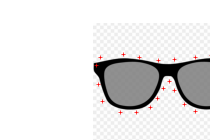

In [122]:
img.prompt_set_mask()

<Figure size 432x288 with 0 Axes>

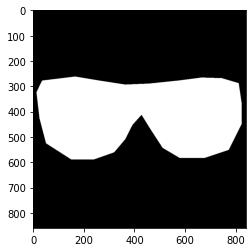

In [123]:
img.assign_mask()

<IPython.core.display.Javascript object>


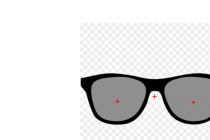

array([[0., 0.],
       [0., 0.],
       [0., 0.]], dtype=float32)

In [124]:
img.prompt_feature_selection()

array([[209.20099, 406.0342 ],
       [426.4793 , 350.727  ],
       [659.5597 , 421.83627]], dtype=float32)

In [175]:

def prompt_point_selection(image, size):
    fig = plt.figure()
    plt.imshow(image, cmap='gray')
    fig.set_label('Click on two points for alignment')
    plt.axis('off')
    xs = []
    ys = []
    clicked = np.zeros((size, 2), dtype=np.float32)

    # Define a callback function that will update the textarea
    def onmousedown(event):
        x = event.xdata
        y = event.ydata
        xs.append(x)
        ys.append(y)

        plt.plot(x, y, 'r-+')

    def onmouseup(event):
        if(len(xs) >= 2):
            plt.close(fig)

    def onclose(event):
        clicked[:, 0] = xs
        clicked[:, 1] = ys
    # Create an hard reference to the callback not to be cleared by the garbage
    # collector
    fig.canvas.mpl_connect('button_press_event', onmousedown)
    fig.canvas.mpl_connect('button_release_event', onmouseup)
    fig.canvas.mpl_connect('close_event', onclose)

    return clicked

In [7]:
# switch from notebook to inline if using colab or otherwise cannot use interactive display)
%matplotlib notebook  
import matplotlib.pyplot as plt

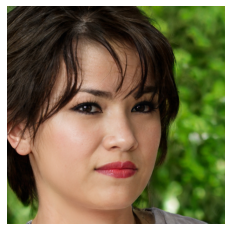

In [109]:
person = cv2.cvtColor(cv2.imread('thispersondoesnotexist.jpeg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0
person_output = prompt_point_selection(person, 3)

In [174]:
person_output

array([[0., 0.],
       [0., 0.],
       [0., 0.]], dtype=float32)

<IPython.core.display.Javascript object>


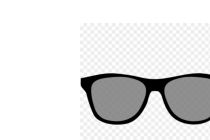

In [149]:
sunglasses = cv2.imread('sunglasses.png')

output_points = prompt_eye_selection(sunglasses)

In [148]:
start = output_points
end = person_output

M = cv2.getAffineTransform(start,end)
# rotation = cv2.getRotationMatrix2D((cols/2,rows/2),90,1)

# scale = np.sqrt(end**2 - start**2)
# translation = 

# transform = cv2.getPerspectiveTransform(start, end)
warp = cv2.warpAffine(sunglasses, M, person.shape[:2])

plt.figure()
plt.imshow(warp)

[[0. 0.]
 [0. 0.]]
(2, 2) (3, 2)


error: OpenCV(4.5.4) /tmp/pip-req-build-kv0l0wqx/opencv/modules/imgproc/src/imgwarp.cpp:3399: error: (-215:Assertion failed) src.checkVector(2, CV_32F) == 3 && dst.checkVector(2, CV_32F) == 3 in function 'getAffineTransform'


If it doesn't get you to the drawing mode, then rerun this function again.


<IPython.core.display.Javascript object>


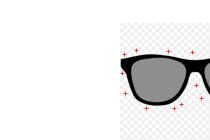

In [30]:
import matplotlib.pyplot as plt
%matplotlib notebook
mask_coords = utils.specify_mask(sunglasses)

(859, 840)


<Figure size 432x288 with 0 Axes>

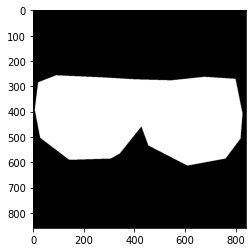

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt
xs = mask_coords[0]
ys = mask_coords[1]
plt.figure()
object_mask = utils.get_mask(ys, xs, sunglasses)

print(object_mask.shape)

object_mask_warp_3d = np.zeros((object_mask.shape[0], object_mask.shape[1], 3))
object_mask_warp_3d[:, :, 0] = object_mask
object_mask_warp = cv2.warpAffine(object_mask_warp_3d, M, person.shape[:2])[:, :, 0]

In [42]:
def get_neighbors(i, j):
    return [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]

def mixed_blend(object_img, object_mask, bg_img, bg_ul):
    """
    Returns a mixed gradient blended image with masked object_img over the bg_img at position specified by bg_ul.
    Can be implemented to operate on a single channel or multiple channels
    :param object_img: the image containing the foreground object
    :param object_mask: the mask of the foreground object in object_img
    :param background_img: the background image 
    :param bg_ul: position (row, col) in background image corresponding to (0,0) of object_img 
    """
    #TO DO   
    object_img_shift = np.zeros(bg_img.shape, dtype='double')
    mask_shift = np.zeros(bg_img.shape)
            
    a, b = np.where(object_mask==1)
    
    mask_indices = list(zip(a, b))
    
    im_w, im_h = bg_img.shape
    m = len(mask_indices) * 4
    n = im_w * im_h
    
    A = scipy.sparse.lil_matrix((m, n))
    b = np.zeros(m)
    
    print('A shape:', A.shape)
    
    # Step 2
    im2var = np.arange(im_w * im_h).reshape(im_w, im_h)
    print('im2var shape', im2var.shape)
    
    e = -1
    for x, y in mask_indices:
        for n_x, n_y in get_neighbors(x, y):
            e += 1
            
            A[e, im2var[x][y]] = 1
            
            object_grad = object_img[x, y] - object_img[n_x, n_y]
            bg_grad = bg_img[x, y] - bg_img[n_x, n_y]
            
            grad = object_grad if abs(object_grad) > abs(bg_grad) else bg_grad

            if object_mask[n_x][n_y] == 1:
                A[e, im2var[n_x][n_y]] = -1
                b[e] = grad
                
            else:
                b[e] = grad + bg_img[n_x, n_y]

    A = scipy.sparse.csr_matrix(A)
    v = scipy.sparse.linalg.lsqr(A, b)[0]
    
    to_return = bg_img * (1 - object_mask)
#     v[v<0] = 0
#     v[v>1] = 1
    
    for x, y in mask_indices:
        to_return[x, y] += v[im2var[x][y]]
    return to_return


A shape: (408148, 1048576)
im2var shape (1024, 1024)
A shape: (408148, 1048576)
im2var shape (1024, 1024)
A shape: (408148, 1048576)
im2var shape (1024, 1024)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


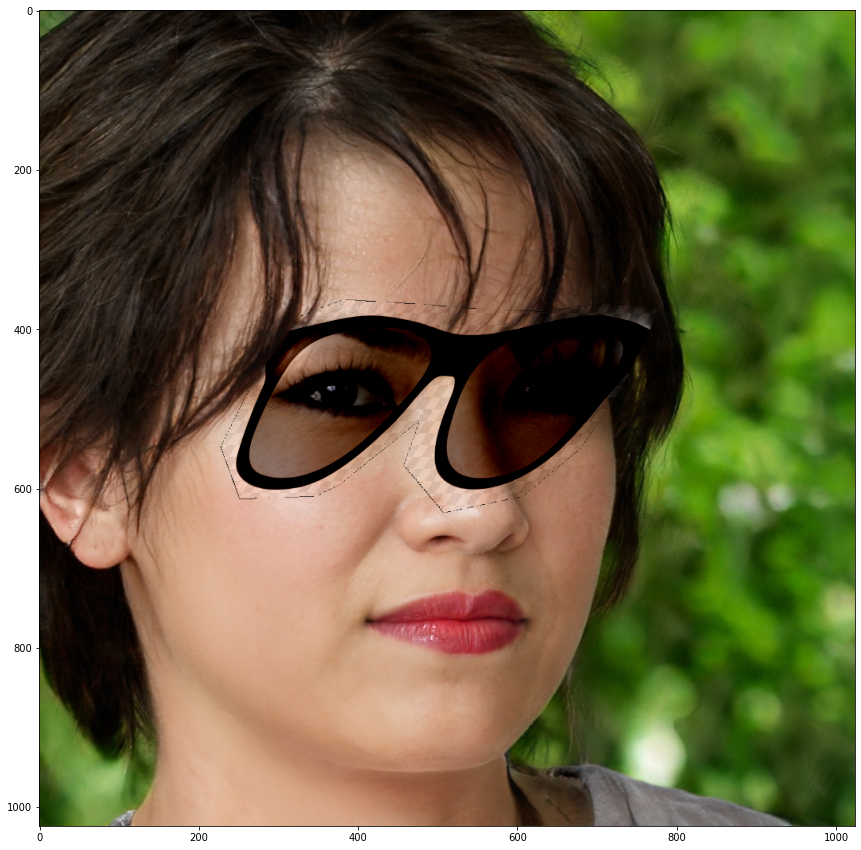

In [52]:
im_mix = np.zeros(person.shape)

for b in np.arange(3):
    im_mix[:,:,b] = mixed_blend(warp[:,:,b].astype('double') / 255, object_mask_warp, person[:,:,b].copy(), (0, 0))

plt.figure(figsize=(15,15))
plt.imshow(im_mix)

In [192]:
# Class that 
class ObjectFilter:
    def __init__(self, predictor, object_filter):
        self.predictor = predictor
        self.object_filter = object_filter

    def place_object(self, face):
        facial_features = self.predictor(face, rect)
        facial_features = shape_to_np(facial_features)
                
        features = np.array([facial_features[39], facial_features[28], facial_features[44]]).astype('float32')
        object_warp, mask_warp = self.get_warps(features.copy(), face)
        
        face = face.astype('double') / 255.0
        im_mix = np.zeros(face.shape)

        for b in np.arange(3):
            im_mix[:,:,b] = mixed_blend(object_warp[:,:,b].astype('double') / 255, mask_warp, face[:,:,b].copy(), (0, 0))

        return im_mix
    
    def get_warps(self, features, face):
        start = self.object_filter.features
        end = features
        
        print(start)
        print(end)
        
        M = cv2.getAffineTransform(start, end)
        warp_object_filter = cv2.warpAffine(self.object_filter.filter_img, M, face.shape[:2])
        
        object_mask_warp_3d = np.zeros((self.object_filter.mask.shape[0], self.object_filter.mask.shape[1], 3))
        object_mask_warp_3d[:, :, 0] = self.object_filter.mask
        object_mask_warp = cv2.warpAffine(object_mask_warp_3d, M, face.shape[:2])[:, :, 0]
        
        plt.figure()
        plt.imshow(warp_object_filter)
        
        return warp_object_filter, object_mask_warp

    def get_neighbors(i, j):
        return [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]

    def mixed_blend(self, object_img, object_mask, bg_img, bg_ul):
        """
        Returns a mixed gradient blended image with masked object_img over the bg_img at position specified by bg_ul.
        Can be implemented to operate on a single channel or multiple channels
        :param object_img: the image containing the foreground object
        :param object_mask: the mask of the foreground object in object_img
        :param background_img: the background image 
        :param bg_ul: position (row, col) in background image corresponding to (0,0) of object_img 
        """
        #TO DO   
        object_img_shift = np.zeros(bg_img.shape, dtype='double')
        mask_shift = np.zeros(bg_img.shape)

        a, b = np.where(object_mask==1)

        mask_indices = list(zip(a, b))

        im_w, im_h = bg_img.shape
        m = len(mask_indices) * 4
        n = im_w * im_h

        A = scipy.sparse.lil_matrix((m, n))
        b = np.zeros(m)

        print('A shape:', A.shape)

        # Step 2
        im2var = np.arange(im_w * im_h).reshape(im_w, im_h)
        print('im2var shape', im2var.shape)

        e = -1
        for x, y in mask_indices:
            for n_x, n_y in get_neighbors(x, y):
                e += 1

                A[e, im2var[x][y]] = 1

                object_grad = object_img[x, y] - object_img[n_x, n_y]
                bg_grad = bg_img[x, y] - bg_img[n_x, n_y]

                grad = object_grad if abs(object_grad) > abs(bg_grad) else bg_grad

                if object_mask[n_x][n_y] == 1:
                    A[e, im2var[n_x][n_y]] = -1
                    b[e] = grad

                else:
                    b[e] = grad + bg_img[n_x, n_y]

        A = scipy.sparse.csr_matrix(A)
        v = scipy.sparse.linalg.lsqr(A, b)[0]

        to_return = bg_img * (1 - object_mask)
    #     v[v<0] = 0
    #     v[v>1] = 1

        for x, y in mask_indices:
            to_return[x, y] += v[im2var[x][y]]
        return to_return
    

In [158]:
# Helper Functions

from collections import OrderedDict

FACIAL_LANDMARKS_68_IDXS = OrderedDict([
    ("mouth", (48, 68)),
    ("inner_mouth", (60, 68)),
    ("right_eyebrow", (17, 22)),
    ("left_eyebrow", (22, 27)),
    ("left_eye", (36, 42)),
    ("right_eye", (42, 48)),
    ("nose", (27, 36)),
    ("jaw", (0, 17))
])

def rect_to_bb(rect):
    x = rect.left()
    y = rect.top()
    w = rect.right() - x
    h = rect.bottom() - y

    return (x, y, w, h)

def shape_to_np(shape, dtype="int"):
    coords = np.zeros((shape.num_parts, 2), dtype=dtype)

    for i in range(0, shape.num_parts):
        coords[i] = (shape.part(i).x, shape.part(i).y)

    return coords

def bounding_box(points):
    min_x, min_y = np.min(points, axis=0)
    max_x, max_y = np.max(points, axis=0)
    return (min_x, min_y, (max_x - min_x), (max_y - min_y))

In [64]:
# Classifiers
eye_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_eye.xml")

dlib_face_detector = dlib.get_frontal_face_detector()
dlib_shape_predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")



[[205.25047 441.19388]
 [414.62778 413.54028]
 [639.8071  445.1444 ]]
[[441. 496.]
 [550. 533.]
 [651. 460.]]


<IPython.core.display.Javascript object>


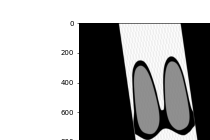

A shape: (768048, 1048576)
im2var shape (1024, 1024)
A shape: (768048, 1048576)
im2var shape (1024, 1024)
A shape: (768048, 1048576)
im2var shape (1024, 1024)


AttributeError: module 'matplotlib.pyplot' has no attribute 'display'

In [193]:
face = cv2.cvtColor(cv2.imread('thispersondoesnotexist.jpeg'), cv2.COLOR_BGR2RGB)

of = ObjectFilter(dlib_shape_predictor, img)

output = of.place_object(face)

plt.display()
plt.imshow(output)

# gray = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
# rects = dlib_face_detector(gray, 2)

# for rect in rects:
#     (x, y, w, h) = rect_to_bb(rect)
    
#     img_result = of.place_object(face, rect)
#     plt.imshow(img_result)


In [190]:
plt.imshow(output / 255)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
